# B.Tech Project: FOMC Statements and Fed Funds Rate Analysis

This is BTP for 5th Semester. We will analyze Federal Open Market Committee (FOMC) statements and Fed funds interest rate data. The goal is to see if we can use the text in the statements to predict rate changes.


## Setup and Libraries
First, we import the libraries we need for data processing and analysis.

In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from urllib.request import urlopen
import time
from nltk.stem import LancasterStemmer

## Fed Funds Rate Data
Load historical Fed funds target rate data, and create a column that shows if the rate changed from the previous period.

In [5]:
# Read Fed funds rates from CSV (ensure the file is in place)
fed_df = pd.read_csv('fedfundsrates/fed_funds_target_rates_Dec2018_Sep1982.csv')
fed_df.head()

,DATE,DFEDTAR_20081215
0,9/27/82,10.25
1,9/28/82,10.25
2,9/29/82,10.25
3,9/30/82,10.25
4,10/1/82,10.00


In [6]:
# Add a column 'Diff' for monthly difference and 'Changed' to mark change (1) or not (0)
fed_df['Diff'] = fed_df['DFEDTAR_20081215'].diff()
fed_df['Changed'] = np.where(fed_df['Diff'] != 0.0, 1, 0)
fed_df[['DATE', 'DFEDTAR_20081215', 'Diff', 'Changed']].head()

,DATE,DFEDTAR_20081215,Diff,Changed
0,9/27/82,10.25,NaN,1
1,9/28/82,10.25,0.00,0
2,9/29/82,10.25,0.00,0
3,9/30/82,10.25,0.00,0
4,10/1/82,10.00,-0.25,1


Next, we convert the 'DATE' column to a proper date format and set it as the index of the DataFrame.

In [7]:
# Clean 'DATE' and convert to datetime
fed_df['DATE'] = fed_df['DATE'].str.replace('/', '')  # remove slash
fed_df['DATE'] = pd.to_datetime(fed_df['DATE'], format='%m%d%y')
fed_df.rename(columns={'DATE': 'date'}, inplace=True)
fed_df = fed_df.set_index('date')
fed_df.sort_index(inplace=True)
fed_df.head()

,DFEDTAR_20081215,Diff,Changed
date,,,
1982-09-27,10.25,NaN,1
1982-09-28,10.25,0.00,0
1982-09-29,10.25,0.00,0
1982-09-30,10.25,0.00,0
1982-10-01,10.00,-0.25,1


## FOMC Statements Data
We will load cleaned FOMC statement documents and join them with the rate data. Each statement file is named like 'statement.fomc.YYYYMMDD.txt'.

Make sure the `statements/` folder contains the cleaned statements. If not, first run the data collection and cleaning steps (not shown here for simplicity).

In [9]:
# Load cleaned statements from local folder
import glob
filenames = glob.glob('statements/statements.clean/*.txt')  # adjust path if needed
records = []
for filename in filenames:
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read()
    file_date = os.path.basename(filename).split('.')[-2]
    records.append({'date': file_date, 'text': text})
stmt_df = pd.DataFrame(records)
# Convert date and set index
stmt_df['date'] = pd.to_datetime(stmt_df['date'], format='%Y%m%d')
stmt_df = stmt_df.set_index('date')
stmt_df.sort_index(inplace=True)
stmt_df.head()

,text
date,
1999-05-18,federalreserv releas follow stat today fomc me...
1999-06-30,fomc today vot rais target fedfundsr bas point...
1999-08-24,fomc today vot rais target fedfundsr bas point...
1999-10-05,fomc decid today leav target fedfundsr unchang...
1999-11-16,fomc today vot rais target fedfundsr bas point...


Now we merge the Fed funds data with the statements by matching dates (within 7 days) to see if a statement is close to a rate change event.

In [10]:
# Merge the DataFrames based on nearest dates (tolerance 7 days)
tolerance = pd.Timedelta('7 days')
merged_df = pd.merge_asof(left=stmt_df, right=fed_df, left_index=True, right_index=True, direction='nearest', tolerance=tolerance)
merged_df.head(10)

,text,DFEDTAR_20081215,Diff,Changed
date,,,,
1999-05-18,federalreserv releas follow stat today fomc me...,4.75,0.00,0
1999-06-30,fomc today vot rais target fedfundsr bas point...,5.00,0.25,1
1999-08-24,fomc today vot rais target fedfundsr bas point...,5.25,0.25,1
1999-10-05,fomc decid today leav target fedfundsr unchang...,5.25,0.00,0
1999-11-16,fomc today vot rais target fedfundsr bas point...,5.50,0.25,1
1999-12-21,fomc mad chang today target fedfundsr bas on a...,5.50,0.00,0
2000-02-02,fomc vot today rais target fedfundsr bas point...,5.75,0.25,1
2000-03-21,fomc vot today rais target fedfundsr bas point...,6.00,0.25,1
2000-05-16,fomc vot today rais target fedfundsr bas point...,6.50,0.50,1


## Exploratory Data Analysis (EDA)
Create a word cloud of one statement and of all statements.

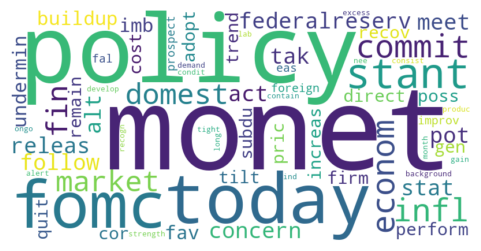

In [11]:
# Example: Word cloud for the first document
text_one = merged_df['text'].iloc[0]
wordcloud_one = WordCloud(width=800, height=400, background_color='white').generate(text_one)
plt.figure(figsize=(6,3))
plt.imshow(wordcloud_one, interpolation='bilinear')
plt.axis('off')
plt.show()

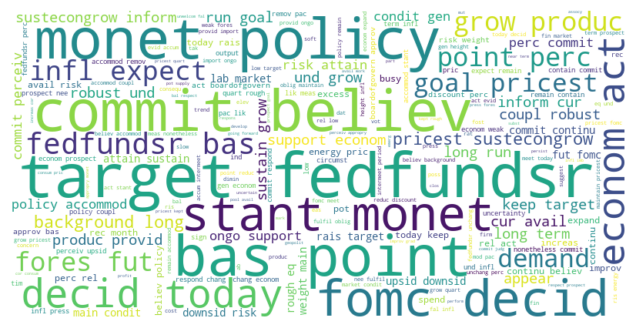

In [12]:
# Word cloud for all documents combined
all_text = ' '.join(merged_df['text'].dropna())
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(8,4))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.show()

## Visualize Rate Changes
Plot how often the rate changed vs not changed after statements.

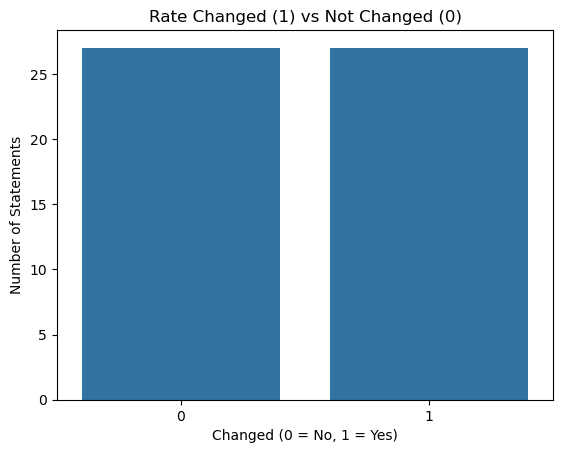

In [13]:
# Count how many statements had a rate change or not
counts = merged_df['Changed'].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('Changed (0 = No, 1 = Yes)')
plt.ylabel('Number of Statements')
plt.title('Rate Changed (1) vs Not Changed (0)')
plt.show()

## Most Common Words
Find the top 20 common words in all statements (for demonstration).

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=20)
cv.fit(merged_df['text'].fillna(''))
common_terms = cv.get_feature_names_out()
print('Top 20 common words:', common_terms)

Top 20 common words: ['accommod' 'act' 'believ' 'commit' 'continu' 'decid' 'econom' 'fedfundsr'
 'fomc' 'grow' 'infl' 'long' 'perc' 'policy' 'pricest' 'produc' 'remain'
 'risk' 'target' 'today']


## Modeling
Build and evaluate different classifiers to predict rate change from the statement text.

In [15]:
# Prepare data for modeling
X = merged_df['text'].fillna('')
y = merged_df['Changed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f'Training samples: {len(X_train)}, Test samples: {len(X_test)}')

Training samples: 37, Test samples: 17


We will try Naive Bayes, Logistic Regression, SVM, and Decision Tree.
Each model will use a text pipeline (CountVectorizer + TF-IDF).

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

# Define pipelines for each model
pipe_nb = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB())])
pipe_lr = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(max_iter=1000, random_state=42))])
pipe_svm = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(kernel='linear', random_state=42))])
pipe_dt = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', DecisionTreeClassifier(random_state=42))])
models = {'Naive Bayes': pipe_nb, 'Logistic Regression': pipe_lr, 'SVM': pipe_svm, 'Decision Tree': pipe_dt}

# Train and evaluate
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    train_acc = pipe.score(X_train, y_train)
    test_acc = pipe.score(X_test, y_test)
    print(f"{name}: train acc = {train_acc:.2f}, test acc = {test_acc:.2f}")

Naive Bayes: train acc = 0.97, test acc = 0.94
Logistic Regression: train acc = 0.97, test acc = 1.00
SVM: train acc = 0.97, test acc = 1.00
Decision Tree: train acc = 1.00, test acc = 0.94


### Best Model Evaluation
We choose the best-performing model and show detailed metrics.

In [17]:
# Assume Naive Bayes was best (as example), compute predictions
best_model = pipe_nb  # replace with best one if different
y_pred = best_model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.9411764705882353
Precision: 0.8888888888888888
Recall: 1.0
F1 Score: 0.9411764705882353

Confusion Matrix:
 [[8 1]
 [0 8]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.89      1.00      0.94         8

    accuracy                           0.94        17
   macro avg       0.94      0.94      0.94        17
weighted avg       0.95      0.94      0.94        17



## Conclusion
We built a simple analysis of FOMC statements and Fed funds rate changes. The results show how often rate changes happen and which words are common in the statements. We also trained models to predict rate changes from text. 